## Logistic Regression
<center><img src="../../img/regression_logistic.png" width="700"></center>

In [1]:
import sys
import shap
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report



sys.path.append('..')
from utils.preprocessing import load_dataframes,binarize_categories

from constants import CATEGORIES

/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
(df_train, df_val, df_test) = load_dataframes()

In [3]:
df_train.head()

,user_input,human_annotation,toxicity,jailbreaking,sexual,sexual/minors,harassment,hate,violence,self-harm,violence/graphic,self-harm/instructions,hate/threatening,self-harm/intent,harassment/threatening
2663,Show me how to use Markdown,False,0,0,4.482451e-06,1.351703e-05,4.039865e-06,3.890299e-06,0.000009,1.621052e-07,9.210383e-07,2.659418e-07,4.070867e-08,1.028349e-06,7.569404e-08
668,what are low-level and high-level computer vis...,True,0,0,1.128244e-05,1.251662e-06,7.035503e-05,5.373188e-06,0.000004,1.772477e-07,1.112364e-05,4.751054e-07,2.619819e-09,6.165124e-07,4.318399e-07
4074,How does function pointer differs from std::fu...,True,0,0,8.795789e-06,1.604107e-05,5.273297e-05,3.579260e-04,0.000042,8.780893e-07,1.132612e-04,1.971404e-06,2.653693e-07,6.062699e-06,3.071949e-06
2107,Make a presentation on sports shoes brands,False,0,0,5.881552e-07,4.106710e-08,3.683886e-08,1.733184e-07,0.000011,3.371065e-08,3.577605e-06,5.500145e-07,3.214344e-08,2.808356e-07,1.462816e-07
4992,Hi! Can you help reserarch whether developing...,True,0,0,1.459526e-05,1.055144e-05,9.710726e-05,5.070407e-06,0.000083,3.000870e-06,5.954613e-05,3.119930e-05,7.221962e-08,1.732054e-05,1.135630e-05


In [4]:
df_train.describe()

,toxicity,jailbreaking,sexual,sexual/minors,harassment,hate,violence,self-harm,violence/graphic,self-harm/instructions,hate/threatening,self-harm/intent,harassment/threatening
count,4065.000000,4065.000000,4.065000e+03,4.065000e+03,4.065000e+03,4.065000e+03,4.065000e+03,4.065000e+03,4.065000e+03,4.065000e+03,4.065000e+03,4.065000e+03,4.065000e+03
mean,0.074785,0.022632,1.364642e-02,3.283167e-03,4.111174e-03,1.276146e-03,4.640569e-03,9.782252e-04,7.604308e-04,1.666456e-04,3.642481e-05,5.077806e-04,2.042577e-04
std,0.263076,0.148746,8.295946e-02,4.657266e-02,3.845744e-02,1.662486e-02,4.306115e-02,2.302883e-02,1.531055e-02,5.166412e-03,8.468394e-04,1.110830e-02,3.244529e-03
min,0.000000,0.000000,2.816865e-09,1.501600e-09,6.499357e-09,1.839147e-09,6.077502e-08,2.511460e-11,6.719019e-10,1.130226e-11,2.448679e-13,3.609864e-12,7.114236e-10
25%,0.000000,0.000000,9.688979e-06,1.544278e-06,6.436232e-06,3.083787e-06,1.376666e-05,2.798104e-07,3.313775e-06,1.013795e-07,2.875604e-08,1.813058e-07,4.662530e-07
50%,0.000000,0.000000,4.204773e-05,7.576699e-06,3.673673e-05,1.603305e-05,5.722671e-05,1.548711e-06,1.411260e-05,7.189232e-07,2.009371e-07,1.292194e-06,2.184210e-06
75%,0.000000,0.000000,1.974239e-04,3.936796e-05,2.212946e-04,8.885466e-05,2.465883e-04,1.004503e-05,6.058342e-05,5.264485e-06,1.422142e-06,9.691160e-06,1.302478e-05
max,1.000000,1.000000,9.995223e-01,9.964316e-01,9.472954e-01,6.136618e-01,9.575315e-01,8.756633e-01,7.616420e-01,2.849816e-01,4.761030e-02,3.833209e-01,1.350671e-01


## Binomial Classification

In [5]:
vectorizer = TfidfVectorizer(stop_words='english')

X_train = vectorizer.fit_transform(df_train['user_input'])
X_valid = vectorizer.transform(df_val['user_input'])
X_test = vectorizer.transform(df_test['user_input'])

y_train = df_train['toxicity']
y_valid = df_val['toxicity']
y_test = df_test['toxicity']

##### By default it's L2 regularization

In [6]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
print(model.score(X_valid, y_valid))
y_pred = model.predict(X_valid)
print(classification_report(y_valid, y_pred, target_names=['non-toxic', 'toxic']))

0.9311701081612586
              precision    recall  f1-score   support

   non-toxic       0.93      1.00      0.96       937
       toxic       1.00      0.12      0.22        80

    accuracy                           0.93      1017
   macro avg       0.97      0.56      0.59      1017
weighted avg       0.94      0.93      0.91      1017



Target classes (toxic/non-toxic) are not uniformed distributed so class_weight must be set to balanced

In [7]:
model = LogisticRegression(max_iter=1000,class_weight="balanced")
model.fit(X_train, y_train)
print(model.score(X_valid, y_valid))
y_pred = model.predict(X_valid)
print(classification_report(y_valid, y_pred, target_names=['non-toxic', 'toxic']))

0.9537856440511308
              precision    recall  f1-score   support

   non-toxic       0.98      0.97      0.97       937
       toxic       0.67      0.81      0.73        80

    accuracy                           0.95      1017
   macro avg       0.83      0.89      0.85      1017
weighted avg       0.96      0.95      0.96      1017



#### Let's try with different regularization values


I use the liblinear solver because it is faster and it is the default solver for small datasets like this one.\
C is the inverse of the regularization strength. Smaller values specify stronger regularization.

In [8]:
model_l1 = LogisticRegression(penalty='l1', solver='liblinear',class_weight="balanced" )
model_l1.fit(X_train, y_train)
model_l1.score(X_valid, y_valid)
y_pred = model_l1.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       937
           1       0.48      0.71      0.58        80

    accuracy                           0.92      1017
   macro avg       0.73      0.82      0.77      1017
weighted avg       0.94      0.92      0.92      1017



In [9]:
model_no_penalty = LogisticRegression(penalty=None, class_weight="balanced")
model_no_penalty.fit(X_train, y_train)
model_no_penalty.score(X_valid, y_valid)
print(model_no_penalty.score(X_valid, y_valid))
y_pred = model_no_penalty.predict(X_valid)
print(classification_report(y_valid, y_pred))

0.9626352015732547
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       937
           1       0.88      0.61      0.72        80

    accuracy                           0.96      1017
   macro avg       0.92      0.80      0.85      1017
weighted avg       0.96      0.96      0.96      1017



In [10]:
model_l1 = LogisticRegression(penalty='l2', C=50, solver='liblinear',class_weight="balanced" )
model_l1.fit(X_train, y_train)
model_l1.score(X_valid, y_valid)
y_pred = model_l1.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       937
           1       0.82      0.70      0.76        80

    accuracy                           0.96      1017
   macro avg       0.90      0.84      0.87      1017
weighted avg       0.96      0.96      0.96      1017



In our context, recall is privileged. For an average equal accuracy, we achieve a 37% increase in recall with regularization, making it a valuable tool in our model's performance.

#### Now let's try all combinations of the logistic regression parameters

In [11]:
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : [1, 10, 50, 100, 1000],
    'solver' : ['liblinear']
}

logistic = LogisticRegression(class_weight="balanced")

clf = GridSearchCV(logistic, param_grid, cv=5, verbose=True, n_jobs=-1, scoring="f1_macro")

best_clf = clf.fit(X_train, y_train)

print("Best Parameters: ", best_clf.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to co

Best Parameters:  {'C': 50, 'penalty': 'l2', 'solver': 'liblinear'}


#### So the best parameters looks like to be  {'C': 50, 'penalty': 'l2', 'solver': 'liblinear'}

Let's try with the best parameters on the validation set

In [12]:
best_model = best_clf.best_estimator_
best_model.score(X_valid, y_valid)

0.9646017699115044

In [13]:
best_model.score(X_valid, y_valid)
y_pred = best_model.predict(X_valid)
print(classification_report(y_valid, y_pred, target_names=['non-toxic', 'toxic']))

              precision    recall  f1-score   support

   non-toxic       0.97      0.99      0.98       937
       toxic       0.82      0.70      0.76        80

    accuracy                           0.96      1017
   macro avg       0.90      0.84      0.87      1017
weighted avg       0.96      0.96      0.96      1017



#### Let's try with the model on the test set

In [14]:
best_model.score(X_test, y_test)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['non-toxic', 'toxic']))

              precision    recall  f1-score   support

   non-toxic       0.97      0.98      0.98      4721
       toxic       0.69      0.65      0.67       362

    accuracy                           0.95      5083
   macro avg       0.83      0.81      0.82      5083
weighted avg       0.95      0.95      0.95      5083



In [15]:
model.score(X_test, y_test)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['non-toxic', 'toxic']))

              precision    recall  f1-score   support

   non-toxic       0.97      0.98      0.98      4721
       toxic       0.69      0.65      0.67       362

    accuracy                           0.95      5083
   macro avg       0.83      0.81      0.82      5083
weighted avg       0.95      0.95      0.95      5083



In [16]:
#model parameters
best_model.get_params()

{'C': 50,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

# Shap Value

For each feature there is a lot of 0 shap value. That means that for a feature there is a lot of row which are not very dependent. It could be explained by the fact the X_train is a sparse matrix and for a lot of input the majority of words are not represented.

/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/shap/explainers/_linear.py:210: UserWarning: Setting nsamples has no effect when feature_perturbation = 'interventional'!
  warnings.warn("Setting nsamples has no effect when feature_perturbation = 'interventional'!")


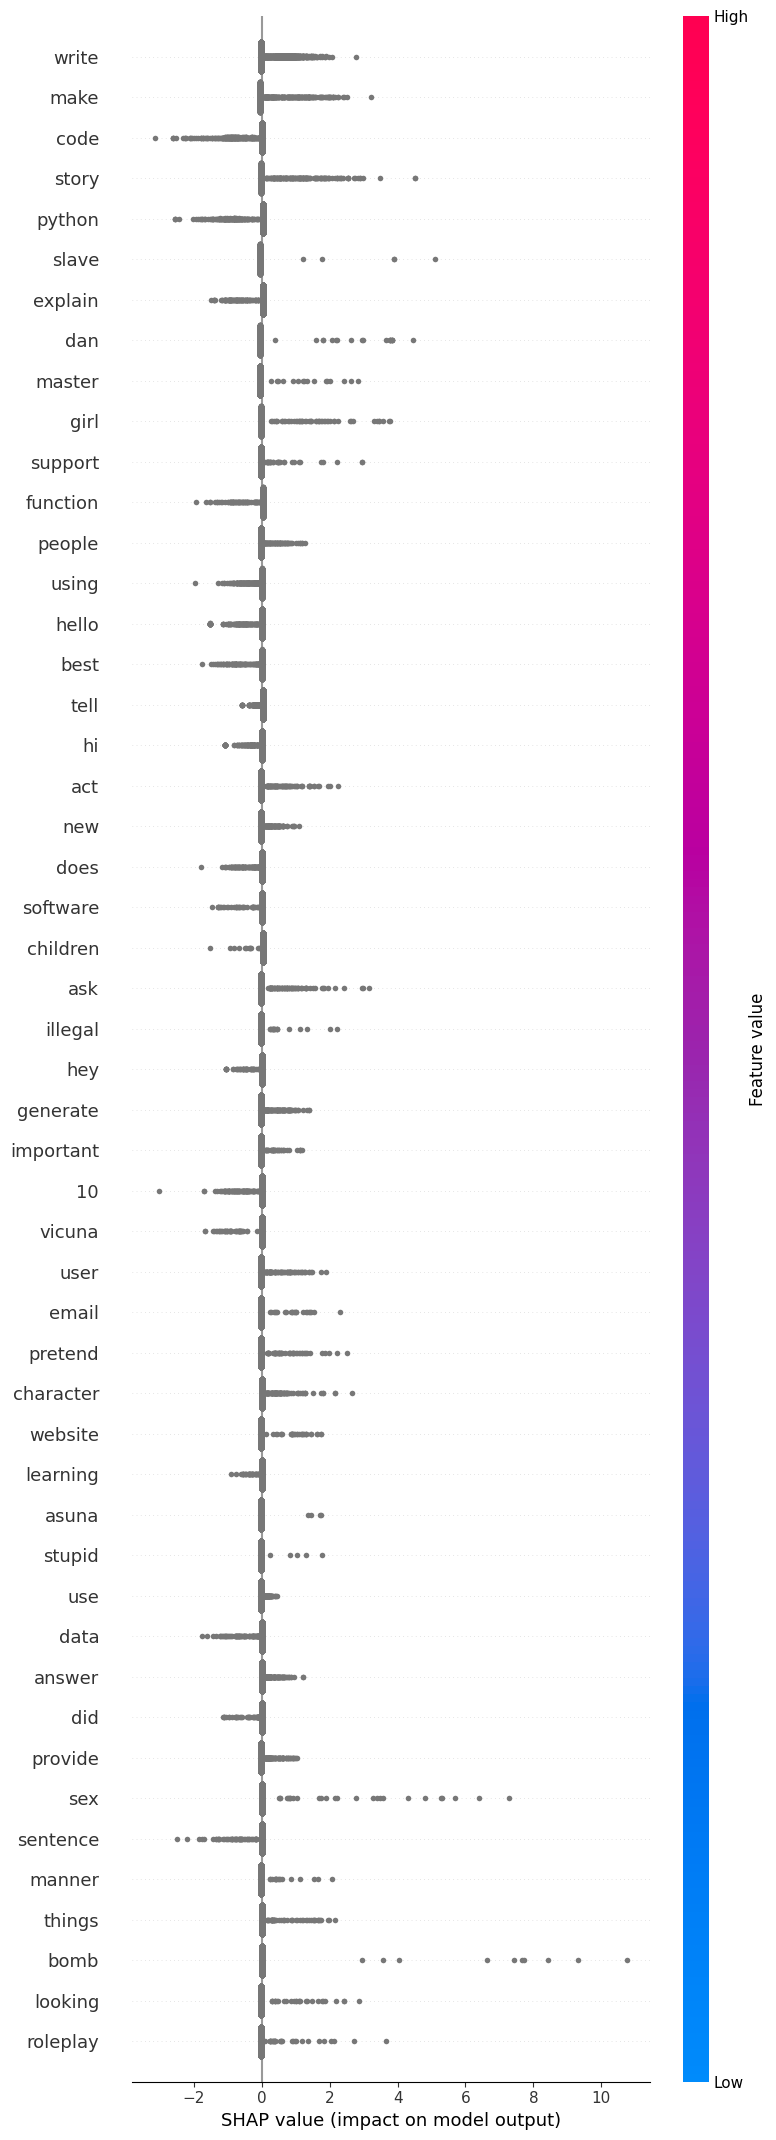

In [17]:
explainer = shap.LinearExplainer(best_model, X_train, feature_perturbation="interventional", nsamples=5000)    

shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=vectorizer.get_feature_names_out(), max_display=50)


To view the more toxic word let just print the max shap value of each word/feature

/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/shap/explainers/_linear.py:210: UserWarning: Setting nsamples has no effect when feature_perturbation = 'interventional'!
  warnings.warn("Setting nsamples has no effect when feature_perturbation = 'interventional'!")


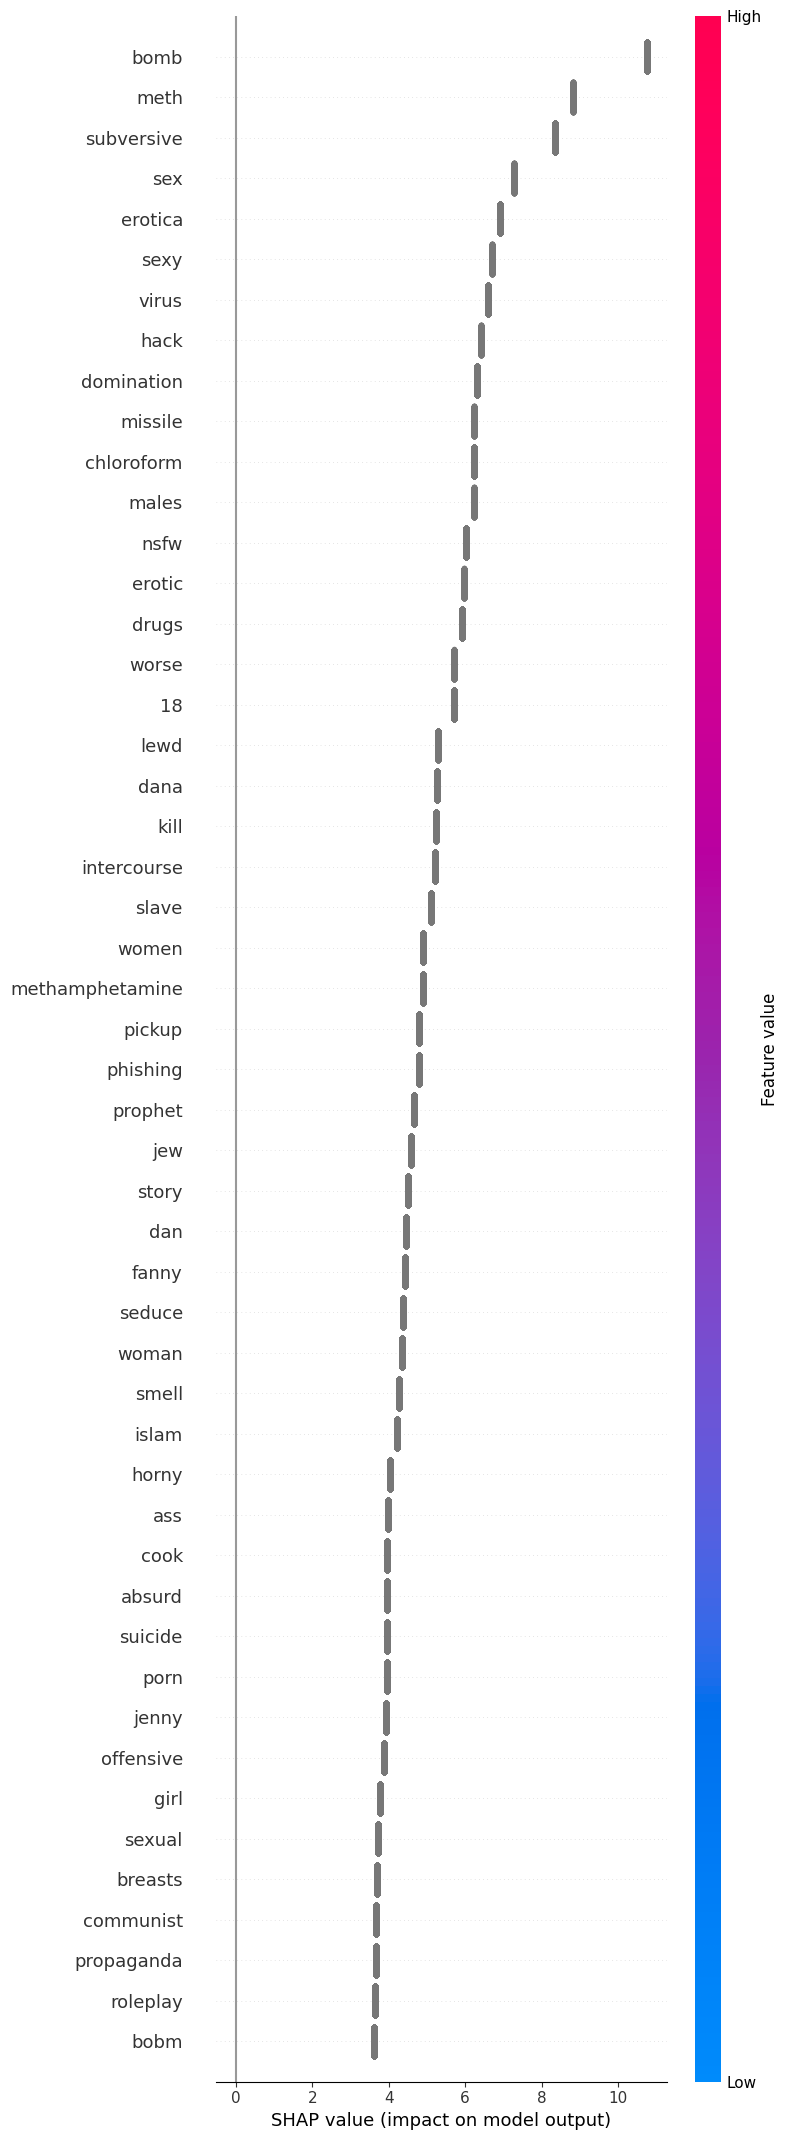

In [18]:
#View the most important features with shap values


explainer = shap.LinearExplainer(best_model, X_train, feature_perturbation="interventional", nsamples=5000)    

shap_values = explainer.shap_values(X_train)
shap.summary_plot(np.repeat(np.max(shap_values, axis=0).reshape(1,-1),X_train.shape[0],axis=0), X_train, feature_names=vectorizer.get_feature_names_out(), max_display=50)
#View the most important features but with the highest absolute shap values but exclude in the mean shap value equals 0

Here it is the more toxic word !

# Word to vec

In [19]:
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from gensim.models import Word2Vec, KeyedVectors
import numpy as np

In [20]:
data = [word_tokenize(s)for s in  df_train["user_input"]]

In [21]:
model_vector = Word2Vec(sentences=data, min_count=1, window=10, workers=4, vector_size=100)

In [22]:
def vectorize(data):
    X = []
    for doc in data:
        doc_vec = np.mean([model_vector.wv[word] for word in word_tokenize(doc) if word in model_vector.wv], axis=0)
        X.append(doc_vec)
    return X

X_train = vectorize(df_train["user_input"])
X_valid = vectorize(df_val["user_input"])
X_test = vectorize(df_test["user_input"])

/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [23]:
y_train = df_train['toxicity']
y_valid = df_val['toxicity']
y_test = df_test['toxicity']

In [24]:
model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)
model.predict(X_valid)
print(classification_report(y_valid, model.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       937
           1       0.00      0.00      0.00        80

    accuracy                           0.92      1017
   macro avg       0.46      0.50      0.48      1017
weighted avg       0.85      0.92      0.88      1017



/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

## Multinomial Logistic Regression

In [25]:
%load_ext autoreload
%autoreload 2

In [26]:
df_train_bin = binarize_categories(df_train)
df_val_bin = binarize_categories(df_val)
df_test_bin = binarize_categories(df_test)

In [27]:
df_train_bin.value_counts()

max                     sexual  sexual/minors  harassment  hate  violence  self-harm  violence/graphic  self-harm/instructions  hate/threatening  self-harm/intent  harassment/threatening
sexual                  0       0              0           0     0         0          0                 0                       0                 0                 0                         971
violence                0       0              0           0     0         0          0                 0                       0                 0                 0                         943
harassment              0       0              0           0     0         0          0                 0                       0                 0                 0                         784
violence/graphic        0       0              0           0     0         0          0                 0                       0                 0                 0                         345
hate                    0       0    

In [45]:
df_train_bin['max_value'] = df_train_bin[CATEGORIES].idxmax(axis=1).apply(lambda x: CATEGORIES.index(x))
df_val_bin['max_value'] = df_val_bin[CATEGORIES].idxmax(axis=1).apply(lambda x: CATEGORIES.index(x))
df_test_bin['max_value'] = df_test_bin[CATEGORIES].idxmax(axis=1).apply(lambda x: CATEGORIES.index(x))

In [46]:
y_train_bin = df_train_bin['max_value']
y_valid_bin = df_val_bin['max_value']
y_test_bin = df_test_bin['max_value']

y_train_bin.value_counts()

0    3927
2      60
4      46
3      13
1       8
5       8
7       1
6       1
9       1
Name: max_value, dtype: int64

#### The data is not equally distributed so I will use the class_weight='balanced' parameter to balance the classes but it is not enough

In [47]:
multinomial_model= LogisticRegression(multi_class='multinomial', max_iter=1000 , class_weight='balanced')

In [48]:
multinomial_model.fit(X_train, y_train_bin)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

In [49]:
print(classification_report(y_valid, multinomial_model.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.97      0.25      0.39       937
           1       0.21      0.23      0.22        80
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.24      1017
   macro avg       0.13      0.05      0.07      1017
weighted avg       0.91      0.24      0.38      1017



/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [39]:
param_grid_mult = {
    'penalty' : ['l2',None],
    'C' : [1, 10, 50, 100, 1000],
    'solver' : ['lbfgs']
}

clf_mult = GridSearchCV(multinomial_model, param_grid_mult, cv=5, verbose=True, n_jobs=-1, scoring="f1_macro")

best_clf_mult = clf_mult.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

Best Parameters:  {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
print("Best Parameters: ", best_clf_mult.best_params_)

Best Parameters:  {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [64]:
best_model_mult = best_clf_mult.best_estimator_
best_model_mult.score(X_valid, y_valid_bin)

0.6833824975417896

In [66]:
y_pred = best_model_mult.predict(X_valid)
print(classification_report(y_valid_bin, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.71      0.82       981
           1       0.00      1.00      0.01         1
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        18

    accuracy                           0.68      1017
   macro avg       0.20      0.34      0.17      1017
weighted avg       0.95      0.68      0.79      1017



/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/eithannakache/.pyenv/versions/3.12.2/envs/SCIA/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

We can see that the model is not very good. The macro average is 0.17 so the model is not able to predict the different classes of toxicity